Transform to BOW and TF-IDF (also use other features LDA, Word-Embedding).

Use at least K-means, EM, Hierarchical clustering algorithms to compare.

Evaluation: Calculate Kappa against true authors, Coherence and Silhouette.

Perform Error-Analysis: Identity what were the characteristics of the instance records that threw the machine off, using the top 10 frequent words and/or top collocations.


In [ ]:
import nltk
import random 
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
import pandas as pd
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator 
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer


## Prepare and Preprocessing The data
Prepare the records of 150 words records for each document,

>

In [ ]:
# Clone the entire repo. 
# Children's books
!git clone -l -s git://github.com/YomnaJehad/Data-Science-Applications-NLP-.git cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 77 (delta 33), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (77/77), 2.81 MiB | 2.93 MiB/s, done.
Resolving deltas: 100% (33/33), done.
/content/cloned-repo
GutenBerg_Children_FairyTale_Collection  README.md
gutenberg_drama_nocvels_collection


In [ ]:
#Children's books
names=["India.txt",
       "America.txt",
       "Japan.txt",
       "Russia.txt", 
       "Dutch.txt"]

# #Drama novels
# names = [ "mac.txt",
#           "pygm.txt",
#           "oliver.txt",
#          # "white.txt",
#          # "fair.txt"
#           "pamela.txt",
#          # "eve.txt"
#          # "susan.txt"
#          # "otranto.txt"
#          # "frank.txt",
#         #  "good_evil.txt",
#         #  "moonstone.txt"
#          # "geo.txt",
#          # "opera.txt"
#          "alaska.txt"
# ]
#different genres


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
books_src_txt = []
for i in range(0,len(names)):  
    # Children's books
    f = open("GutenBerg_Children_FairyTale_Collection/"+names[i], "r")
    # Drama novels 
    #f = open("gutenberg_drama_nocvels_collection/"+names[i], "r")
    books_src_txt.append( f.read() )
    f.close()

In [ ]:
# Functions for removing punctuation marks and other not so important tokens
def removeString(data, regex):
    return data.str.lower().str.replace(regex.lower(), ' ')

def cleanDataset(dataset, columnsToClean, regexList):
    for column in columnsToClean:
        for regex in regexList:
            dataset[column] = removeString(dataset[column], regex)
    return dataset

def getRegexList():
    regexList = []
    # regexList += ['From:(.*)\r\n']  # from line
    # regexList += ['RITM[0-9]*'] # request id
    # regexList += ['INC[0-9]*'] # incident id
    # regexList += ['TKT[0-9]*'] # ticket id
    # regexList += ['Sent:(.*)\r\n']  # sent to line
    # regexList += ['Received:(.*)\r\n']  # received data line
    # regexList += ['To:(.*)\r\n']  # to line
    # regexList += ['CC:(.*)\r\n']  # cc line
    # regexList += ['The information(.*)infection']  # footer
    # regexList += ['Endava Limited is a company(.*)or omissions']  # footer
    # regexList += ['The information in this email is confidential and may be legally(.*)interference if you are not the intended recipient']  # footer
    regexList += ['\[cid:(.*)]']  # images cid
    regexList += ['https?:[^\]\n\r]+']  # https & http
    regexList += ['Subject:']
    # regexList += ['[\w\d\-\_\.]+@[\w\d\-\_\.]+']  # emails
    # regexList += ['[0-9][\-0–90-9 ]+']  # phones
    # regexList += ['[0-9]']  # numbers
    regexList += ['[^a-zA-z 0-9]+']  # anything that is not a letter
    regexList += ['[\r\n]']  # \r\n
    regexList += [' [a-zA-Z] ']  # single letters
    regexList += [' [a-zA-Z][a-zA-Z] ']  # two-letter words
    regexList += ["  "]  # double spaces

    regexList += ['^[_a-z0-9-]+(\.[_a-z0-9-]+)*@[a-z0-9-]+(\.[a-z0-9-]+)*(\.[a-z]{2,4})$']
    regexList += ['[\w\d\-\_\.]+ @ [\w\d\-\_\.]+']
    regexList += ['Subject:']
    regexList += ['[^a-zA-Z]']
    regexList += ['said']
    regexList += ['can']
    regexList += ['could']
    regexList += ['should']
    regexList += ['must']
    regexList += ['yet']
    regexList += ['away']
    regexList += ['let']
    regexList += ['day']
    regexList += ['time']
    regexList += ['?']
    regexList += ['!']
    regexList += ['.']
    regexList += ['\"']
    regexList += ['_']
    regexList += ['[']
    regexList += [']']
    regexList += [']']
    regexList += [';']
    regexList += ['\'']
    regexList += ['(']
    regexList += [')']

    return regexList


In [ ]:
def text_total(book_index):
  
  text1=books_src_txt[book_index]
  tokenizer = RegexpTokenizer(r'\w+')
  text2=tokenizer.tokenize(text1)
  stop_words=set(stopwords.words("english"))
  lowercase= [word.lower() for word in text2]
  filtered_sentences = [word for word in lowercase if word not in stop_words]
  porter = PorterStemmer()
  stemmed_output = [porter.stem(w) for w in filtered_sentences]
  lemmatizer = WordNetLemmatizer()
  lemmatized_output = [lemmatizer.lemmatize(w) for w in stemmed_output]

  return lemmatized_output



In [ ]:
def result(books,labels):
  sequence=[]
  label_result=[]
  k=0
  random.seed(42)
  for text in books:
      for i in range(200):
          r=random.randint(0,len(text))
          sequence.append(' '.join(text[r:r+150]))          #Number of words
          label_result.append(labels[k])
      k=k+1
  return sequence, label_result



In [ ]:
texts=[]
for ind in range(len(names)):
  # name=name+'.txt'
  texts.append(text_total(ind))
sequence, labels=result(texts,names)
df = pd.DataFrame({'sequence':sequence, 'labels':labels})
df


,sequence,labels
0,laili laili saw blind pray khuda restor sight ...,India.txt
1,thing stick rope agre princ shot first arrow a...,India.txt
2,heart raja rasalu go potter ask sell kiln pott...,India.txt
3,judgment bustl ceas hall justic close must the...,India.txt
4,never draw bridl find narrow ravin outlet rein...,India.txt
...,...,...
995,put slice meat upper lower layer bread call br...,Dutch.txt
996,one place anoth wild boar hunt death disappear...,Dutch.txt
997,kettl bottl solid ice stoom behav badli frozen...,Dutch.txt
998,curiou red pole heard nobodi yet found red thi...,Dutch.txt


In [ ]:
# Select columns for cleaning
columnsToClean = ['sequence']
df=cleanDataset(df, columnsToClean, getRegexList())
df


,sequence,labels
0,laili laili saw blind pray khuda restor sight ...,India.txt
1,thing stick rope agre princ shot first arrow ...,India.txt
2,heart raja rasalu potter ask sell kiln potter ...,India.txt
3,judgment bustl ceas hall justic close theref...,India.txt
4,never draw bridl find narrow ravin out rein s...,India.txt
...,...,...
995,put slice meat upper lower layer bread call br...,Dutch.txt
996,one place anoth wild boar hunt death disappear...,Dutch.txt
997,kettl bottl solid ice stoom behav badli frozen...,Dutch.txt
998,curiou red pole heard nobodi found red thing...,Dutch.txt


###Labled Word cloud visualization

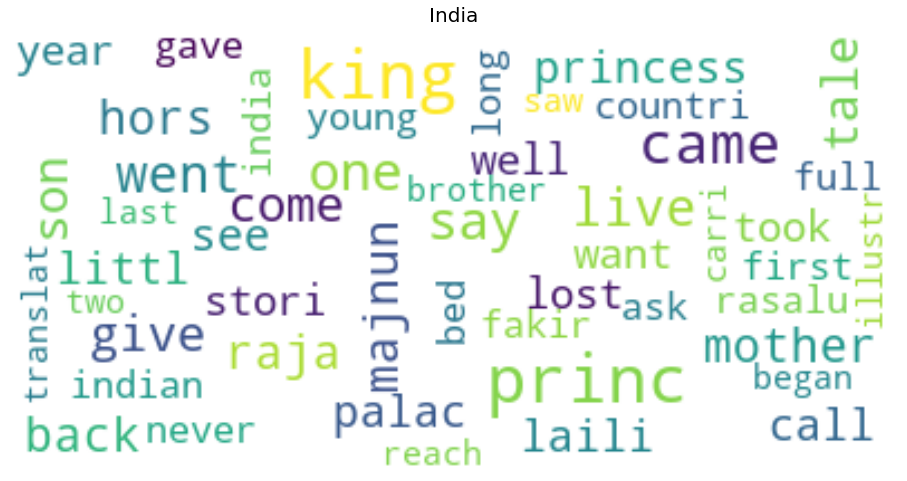

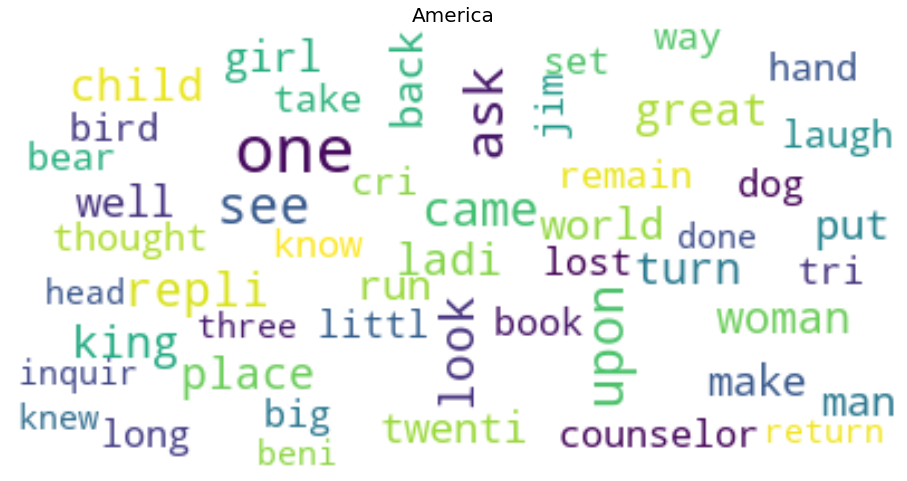

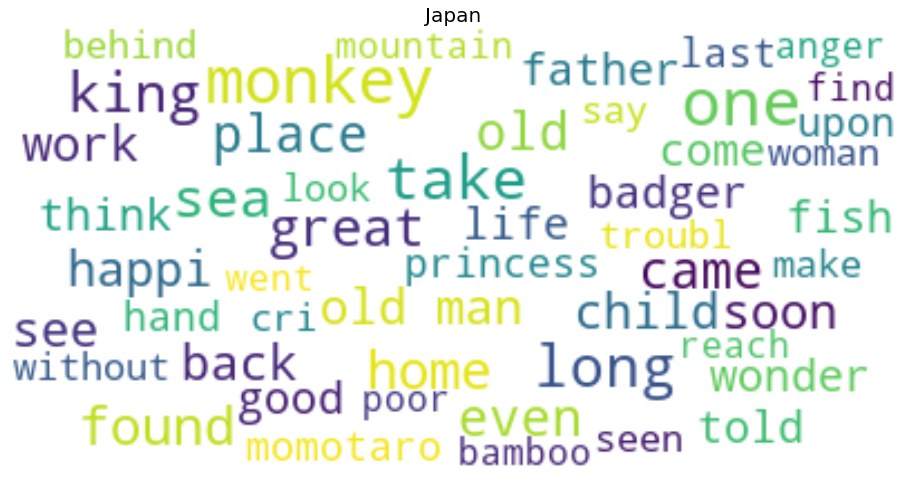

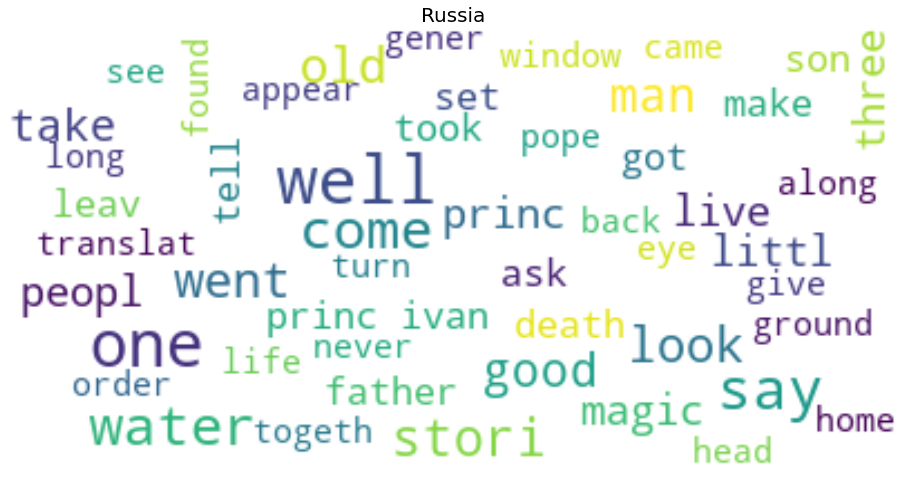

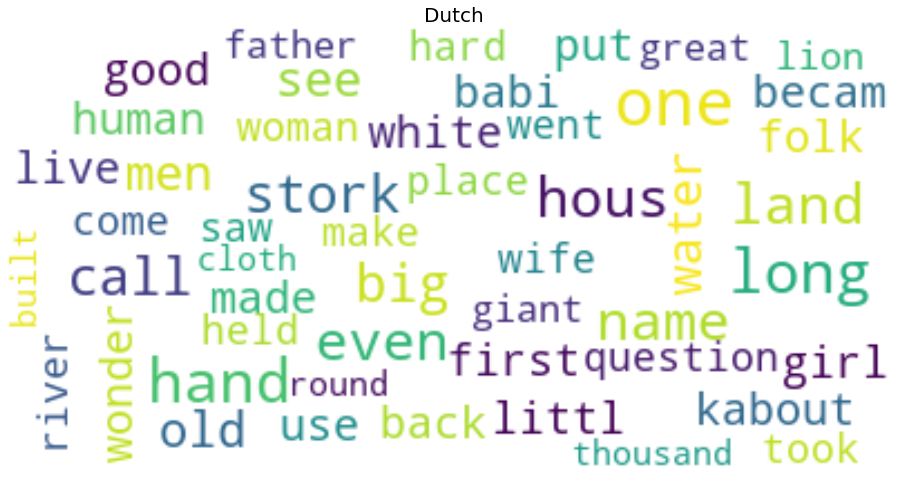

In [ ]:
# names = [ "mac.txt",
#          "pygm.txt",
#          "oliver.txt",
#          #"white.txt",
#          "fair.txt"]
#Generate word cloud
from google.colab import files
for x in names:
    text=df['sequence'][df['labels']==x].to_string()
    #wordcloud = WordCloud(width = 300, height = 200, random_state=1, background_color='white', colormap='steelblue', collocations=False, stopwords = STOPWORDS).generate(text)
    wordcloud = WordCloud(max_font_size=30, max_words=50, background_color="white").generate(text)
    #wordcloud = WordCloud().generate(text)
    # Plot
    plt.figure(figsize=(16, 15))
    plt.title(x[:len(x)-4],fontsize=20)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.gca()
    #plt.savefig(str(x)+".png")
    #files.download(str(x)+".png")

#Clustering Algorithms + Evaluation Functions


In [ ]:
#kmeans 
from sklearn.cluster import KMeans
def kmean(true_k,data):
  pca = PCA(n_components=2)
  X_pca = pca.fit_transform(data)
  model = KMeans(n_clusters=true_k, init='k-means++', max_iter=300)
  labels = model.fit_predict(X_pca)

  return model,labels

In [ ]:
# Hierarchical Agglomerative Clustering Algorithm
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

def agg(true_k,data,dist_fn='euclidean',linkage='ward'):
  pca = PCA(n_components=2)
  X_pca = pca.fit_transform(data)
  model = AgglomerativeClustering(n_clusters=true_k, affinity =dist_fn, linkage=linkage)
  y_hc = model.fit_predict(X_pca)
  return model,y_hc

In [ ]:
#EM
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
def em(true_k,X):
  pca = PCA(n_components=2)
  X_pca = pca.fit_transform(X)
  model = GaussianMixture(n_components=2, init_params='random')
  y_hc = model.fit_predict(X_pca)
  return model,y_hc

In [ ]:
#Evaluations

In [ ]:
#Elbow method
from sklearn.decomposition import PCA
def elbow_pca(data):
  pca = PCA(n_components=2)
  X_pca = pca.fit_transform(data)
  #PCA
  wcss = []
  for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)
  
  plt.plot(range(1, 11,1), wcss)
  plt.title('Elbow Method')
  plt.xlabel('Number of clusters')
  plt.ylabel('WCSS')
  plt.show()
  return X_pca

In [ ]:
#Elbow method
from sklearn.manifold import TSNE
def elbow_tsne(data):
  tsne = TSNE(n_components=2)
  X_tsne = tsne.fit_transform(data)
  #PCA
  wcss = []
  for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_tsne)
    wcss.append(kmeans.inertia_)
  
  plt.plot(range(1, 11,1), wcss)
  plt.title('Elbow Method')
  plt.xlabel('Number of clusters')
  plt.ylabel('WCSS')
  plt.show()
  return X_tsne

In [ ]:
#silhouette
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

def silhouette(X,cluster_labels):
  score = silhouette_score(X,cluster_labels)

  print('Silhouetter Score: %.3f' % score)

 #plot
  fig, ax = plt.subplots(2, 2, figsize=(15,8))
  for i in [2, 3, 4, 5]:

      km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
      q, mod = divmod(i, 2)
    
      visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
      visualizer.fit(X)



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
#Kappa
from scipy import stats
def kappa(cluster_labels):
  from sklearn.metrics import cohen_kappa_score

  true_labels=[]
  for i in range (5):
    k=i*200
    m = stats.mode(cluster_labels[k:k+200])
    true_labels[k:k+200] = np.repeat(m[0],200)

  score = cohen_kappa_score(cluster_labels, true_labels)
  print(score)



In [ ]:
#Coherence
def coherence(model):
  from gensim.models.coherencemodel import CoherenceModel
  #two different implementations of the coherence: umass, c_v
  cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
  coherence = cm.get_coherence() 
  # cm2 = CoherenceModel(model=model, texts=texts, coherence='c_v')
  # coherence_v = cm2.get_coherence() # get coherence value
  perp = model.log_perplexity(corpus)
  print(coherence)
  print(perp)

# Text Clustering

# Feature Generation using Bag of Words




In [ ]:
cv = CountVectorizer(ngram_range = (1,1))
text_counts= cv.fit_transform(df['sequence'])
print("Bag of Words:\n")



Bag of Words:



In [ ]:
#Cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(text_counts.toarray())
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,1.000000,0.223887,0.090943,0.070709,0.118580,0.096544,0.591082,0.022333,0.013918,0.244241,0.113153,0.098041,0.150691,0.111344,0.062933,0.157960,0.159386,0.018113,0.101963,0.017342,0.073705,0.025852,0.125157,0.015737,0.153868,0.103825,0.085488,0.226374,0.237359,0.557816,0.096273,0.237334,0.073961,0.129300,0.256065,0.096781,0.053841,0.026341,0.474299,0.211530,...,0.121787,0.054262,0.053233,0.048779,0.076551,0.105633,0.036224,0.055400,0.074339,0.114429,0.081659,0.089805,0.091759,0.051174,0.055013,0.100900,0.075643,0.030854,0.065735,0.055972,0.133500,0.086041,0.081833,0.089555,0.077879,0.057379,0.087988,0.081942,0.047253,0.077493,0.110014,0.069171,0.047869,0.118593,0.058732,0.073425,0.115548,0.101954,0.062578,0.073920
1,0.223887,1.000000,0.178483,0.135354,0.110342,0.079057,0.151255,0.034007,0.034969,0.460817,0.471183,0.112897,0.182003,0.151959,0.043921,0.576396,0.190111,0.020226,0.117921,0.019365,0.192983,0.061343,0.122285,0.038660,0.246516,0.191292,0.155563,0.183467,0.273075,0.164808,0.134377,0.223171,0.091764,0.109166,0.256688,0.114823,0.112726,0.050422,0.159524,0.191046,...,0.096626,0.081976,0.126809,0.047206,0.077709,0.136384,0.097078,0.160111,0.079057,0.107810,0.148594,0.071031,0.197332,0.046429,0.111341,0.120717,0.092144,0.088594,0.154145,0.045833,0.074536,0.088070,0.063261,0.082143,0.079057,0.079147,0.145556,0.091499,0.150756,0.098331,0.154548,0.091952,0.143653,0.101266,0.118868,0.178885,0.102461,0.045538,0.083853,0.123812
2,0.090943,0.178483,1.000000,0.052759,0.068816,0.074311,0.078986,0.040185,0.007652,0.191391,0.145159,0.067378,0.091303,0.139436,0.017300,0.145776,0.075680,0.059752,0.096100,0.012713,0.637180,0.021320,0.086013,0.006922,0.115246,0.616489,0.142744,0.076281,0.092272,0.095466,0.060492,0.082411,0.072290,0.062419,0.073591,0.352512,0.034535,0.016551,0.141379,0.075252,...,0.070482,0.056156,0.023414,0.064364,0.091827,0.058076,0.095596,0.068083,0.058387,0.066844,0.066512,0.115206,0.067264,0.031652,0.052930,0.118874,0.045369,0.014540,0.061440,0.041030,0.047708,0.035479,0.041530,0.052753,0.058387,0.029691,0.075250,0.052560,0.044536,0.034859,0.050729,0.057950,0.032898,0.053695,0.076690,0.069728,0.059791,0.071001,0.030965,0.033251
3,0.070709,0.135354,0.052759,1.000000,0.076335,0.139433,0.078583,0.016366,0.049085,0.042431,0.059382,0.064829,0.120850,0.112190,0.043595,0.068212,0.113148,0.033460,0.113746,0.020386,0.043535,0.052098,0.135566,0.050742,0.101112,0.047077,0.102090,0.084616,0.169106,0.096228,0.058896,0.072371,0.121446,0.098507,0.155394,0.121896,0.033906,0.003792,0.048942,0.090897,...,0.077503,0.122214,0.132306,0.045873,0.122712,0.096458,0.062049,0.085373,0.057070,0.097284,0.100564,0.079177,0.164367,0.080568,0.062360,0.076251,0.083147,0.057737,0.122535,0.067677,0.107612,0.086696,0.044399,0.112795,0.064204,0.108828,0.160895,0.061924,0.102027,0.099377,0.110851,0.073016,0.093452,0.098407,0.081371,0.057169,0.130124,0.106154,0.081970,0.104952
4,0.118580,0.110342,0.068816,0.076335,1.000000,0.173408,0.110591,0.088055,0.045731,0.147584,0.096043,0.120798,0.206130,0.345511,0.031016,0.140871,0.185670,0.011903,0.320655,0.015195,0.076826,0.025482,0.168600,0.049638,0.175845,0.075049,0.137321,0.177548,0.230024,0.114103,0.122008,0.139542,0.097204,0.140920,0.214159,0.127195,0.050122,0.049455,0.150205,0.192151,...,0.105303,0.138433,0.093282,0.038465,0.086889,0.078091,0.099976,0.149902,0.069786,0.140990,0.107320,0.103273,0.066997,0.105087,0.058745,0.066305,0.108452,0.075308,0.116631,0.068657,0.078954,0.065964,0.082730,0.079866,0.065134,0.110898,0.094224,0.071795,0.057667,0.069440,0.097946,0.056277,0.070776,0.105436,0.096487,0.065795,0.062531,0.089329,0.074020,0.061822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

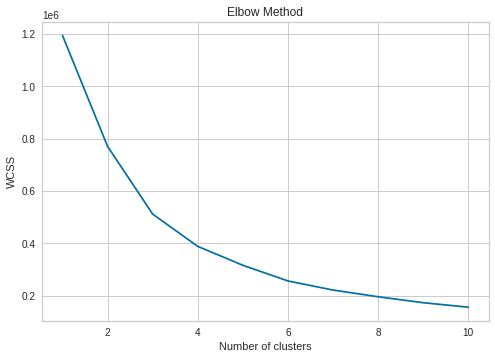

array([[ 56.35269  ,  -4.456342 ],
       [ 43.390453 ,   6.0365853],
       [ 60.00154  ,  17.506039 ],
       ...,
       [ 12.924119 ,  20.374947 ],
       [ 32.675987 , -30.200304 ],
       [ 17.745838 ,  13.509276 ]], dtype=float32)

In [ ]:
elbow_tsne(text_counts.toarray())

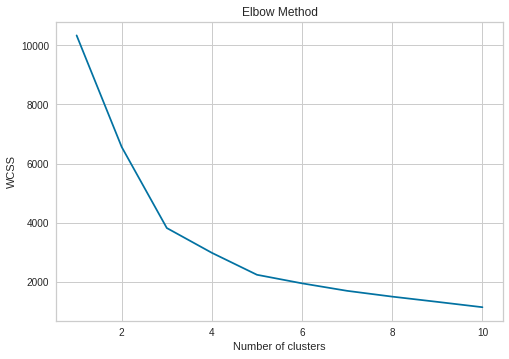

array([[ 5.82306084,  3.50939539],
       [ 3.21498741,  4.33844356],
       [ 1.0221304 ,  0.86151185],
       ...,
       [-1.02203907, -1.04359567],
       [-1.43941275, -1.19391208],
       [-0.96124029, -1.67097454]])

In [ ]:
elbow_pca(text_counts.toarray())

In [ ]:
#k-means
print("k-means:\n")
model,newlables= kmean(5,text_counts.toarray())
#newlables

k-means:



In [ ]:
kappa(newlables)

0.14250353606789257


Silhouetter Score: 0.011


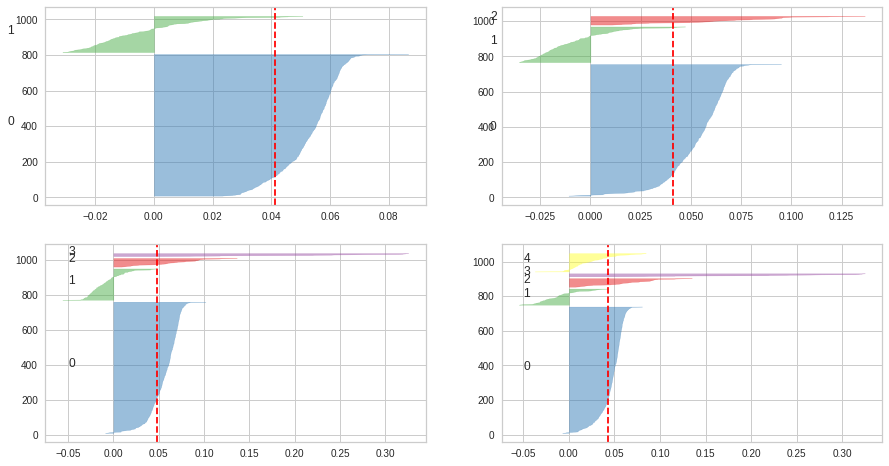

In [ ]:
silhouette(text_counts.toarray(),newlables)

In [ ]:
#Hierarchical Agglomerative Clustering 
print("Hierarchical Agglomerative Clustering:\n")
print("Euclidean distance:\n")
model,newlables= agg(3,text_counts.toarray(),'manhattan','average')

Hierarchical Agglomerative Clustering:

Euclidean distance:



In [ ]:
kappa(newlables)

0.0


Silhouetter Score: 0.127


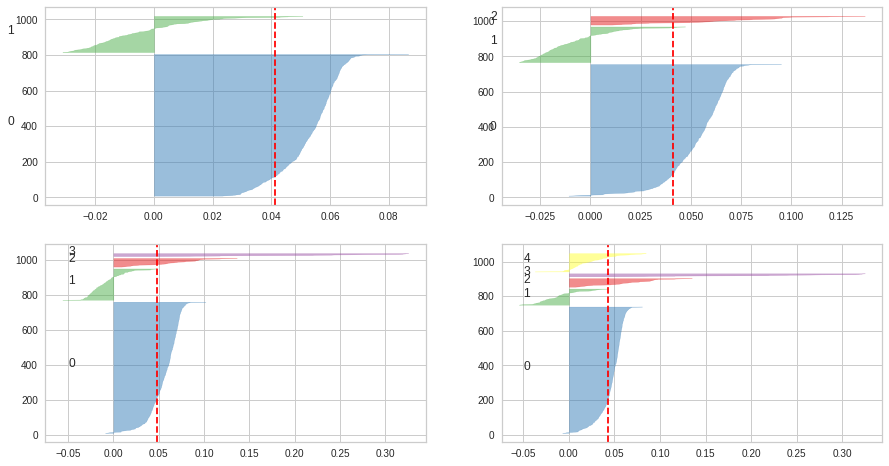

In [ ]:
silhouette(text_counts.toarray(),newlables)

In [ ]:
print("Manhattan distance:\n")
model,newlables= agg(3,text_counts.toarray(),'manhattan','complete')

Manhattan distance:



In [ ]:
kappa(newlables)

0.0


Silhouetter Score: 0.070


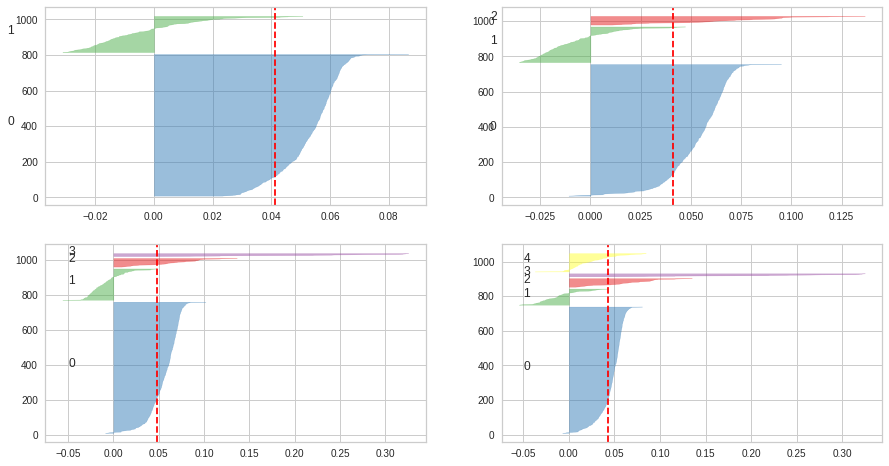

In [ ]:
silhouette(text_counts,newlables)

In [ ]:
#EM
print("EM:\n")
model,newlables= em(5,text_counts.toarray())

EM:



In [ ]:
kappa(newlables)

0.30709802028005806


Silhouetter Score: 0.025


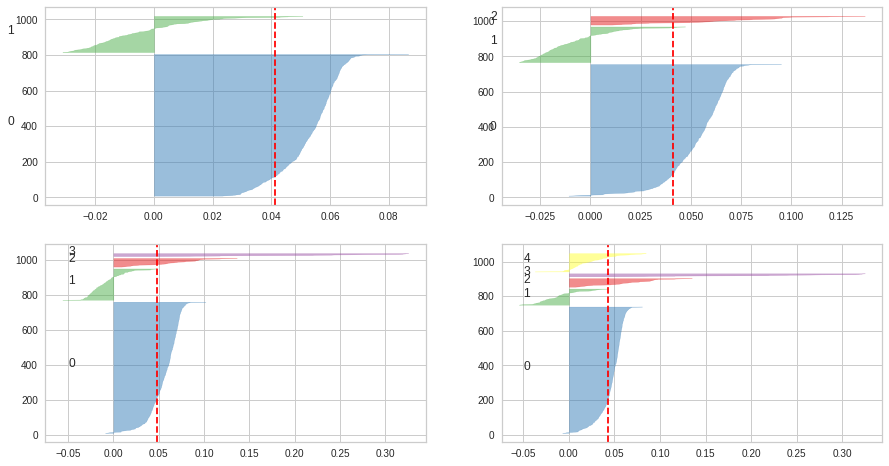

In [ ]:
silhouette(text_counts,newlables)

# Feature Generation using TF-IDF


In [ ]:
tf=TfidfVectorizer()
text_tf= tf.fit_transform(df['sequence'])
print("TF-IDF:\n")

TF-IDF:



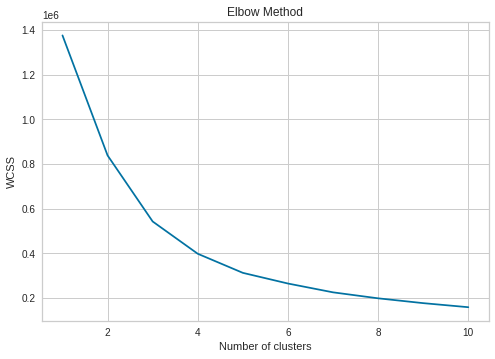

array([[  1.6690397, -34.858597 ],
       [ -2.168195 , -21.934298 ],
       [-33.26472  , -27.257244 ],
       ...,
       [-15.221692 ,  45.961082 ],
       [-19.460796 ,  36.08949  ],
       [ 49.6935   , -27.135492 ]], dtype=float32)

In [ ]:
elbow_tsne(text_tf.toarray())

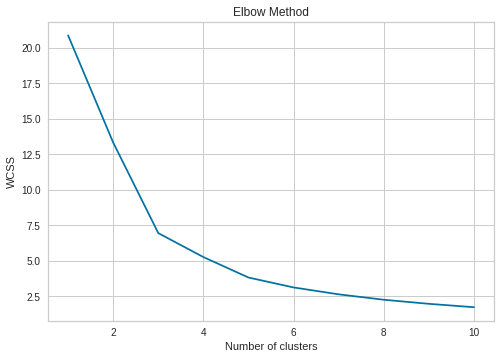

array([[ 0.3965114 ,  0.04098962],
       [ 0.25256739,  0.01156999],
       [ 0.10471474, -0.01817728],
       ...,
       [-0.05201676, -0.0100443 ],
       [-0.07883759, -0.02766935],
       [-0.0779682 ,  0.01552918]])

In [ ]:
elbow_pca(text_tf.toarray())

In [ ]:
#k-means
print("k-means:\n")
model,newlables= kmean(3,text_tf.toarray())

k-means:



In [ ]:
kappa(newlables)

0.42788717402873866


Silhouetter Score: 0.010


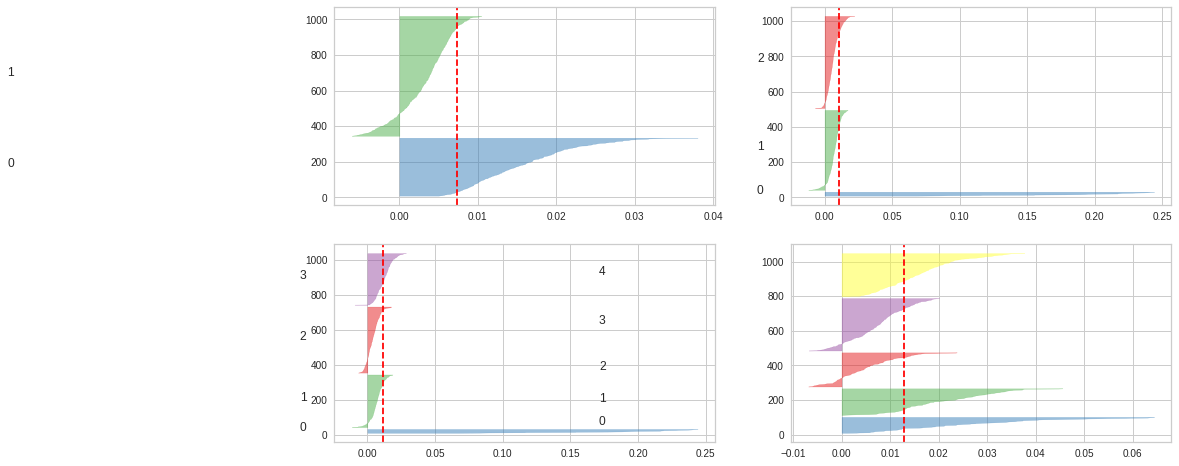

In [ ]:
silhouette(text_tf,newlables)

In [ ]:
#Hierarchical Agglomerative Clustering 
print("Hierarchical Agglomerative Clustering:\n")
model,newlables= agg(3,text_tf.toarray(),'manhattan','average')

Hierarchical Agglomerative Clustering:



In [ ]:
kappa(newlables)

0.0


Silhouetter Score: 0.004


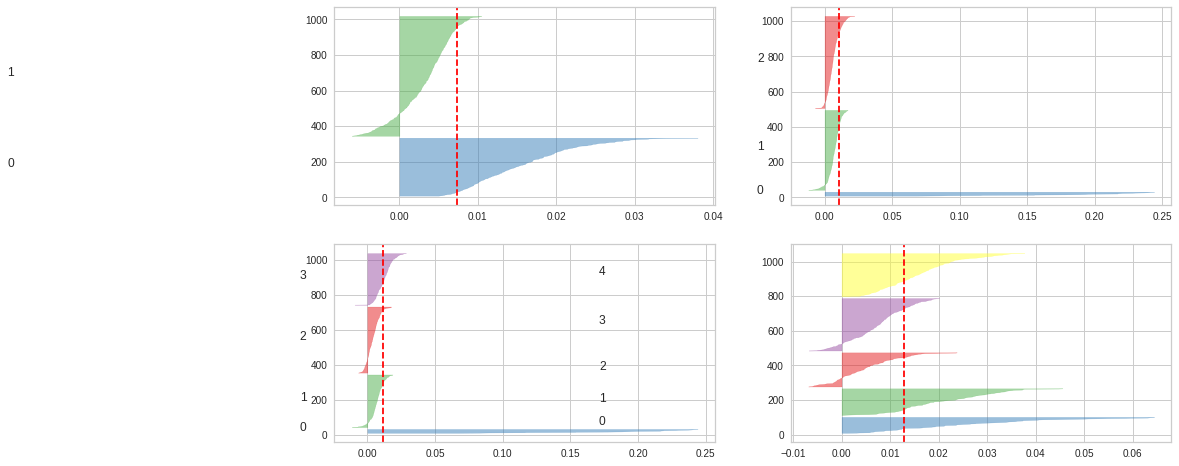

In [ ]:
silhouette(text_tf,newlables)

In [ ]:
#EM
print("EM:\n")
model,newlables= em(3,text_tf.toarray())

EM:



In [ ]:
kappa(newlables)

0.0


Silhouetter Score: 0.009


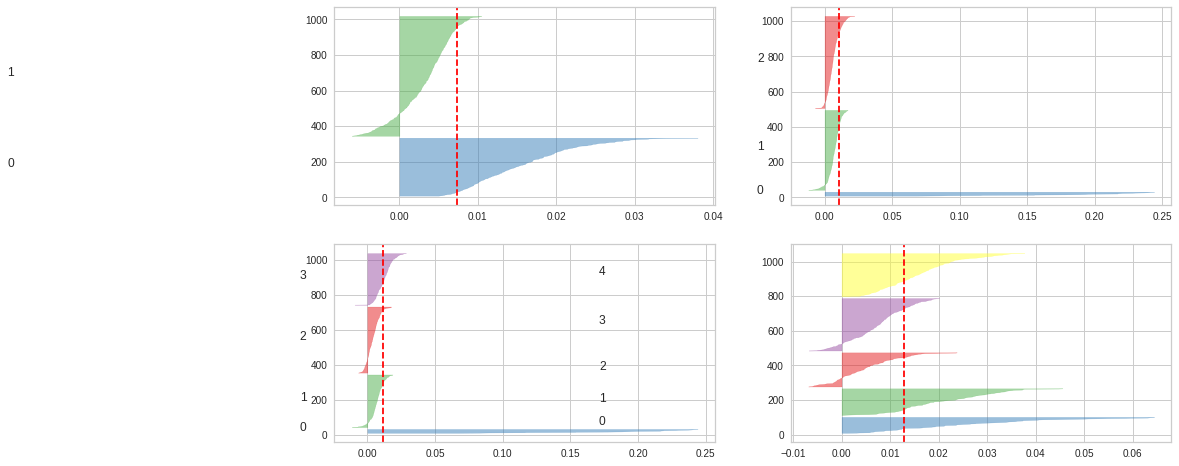

In [ ]:
silhouette(text_tf,newlables)

#Feature Generation using N-gram
>

In [ ]:
def get_ngrams(text, n ):
    n_grams = ngrams(word_tokenize(text), n)
    return [ ' '.join(grams) for grams in n_grams]

In [ ]:
df.sequence=df['sequence'].astype(str)
tokenize=[]
i=0
for i in range (len(df.sequence)):
  #p.append(get_ngrams(df.sequence[i],3))
  tokenize.append(nltk.word_tokenize(df.sequence[i]))


In [ ]:
cv_ngram = CountVectorizer(ngram_range = (iterations2,2))
text_counts_ngram= cv_ngram.fit_transform(df['sequence'])
print("n-gram:\n")

NameError: ignored

In [ ]:
#k-means
print("k-means:\n")
model,newlables= kmean(5,text_counts.toarray())

In [ ]:
kappa(newlables)

In [ ]:
silhouette(text_counts,newlables)

In [ ]:
elbow_tsne(text_counts_ngram.toarray())


In [ ]:
elbow_pca(text_counts_ngram.toarray())


#Doc2Vec

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
tagged_tr = [TaggedDocument(words=word_tokenize(_d.lower()),
tags=[str(i)]) for i, _d in enumerate(df['sequence'])]

In [ ]:
model = Doc2Vec(vector_size=100,
                window=5, 
                alpha=.025, 
                min_alpha=0.00025, 
                min_count=2, 
                dm=1, 
                workers=8)
model.build_vocab(tagged_tr)

In [ ]:
epochs = range(100)
for epoch in epochs:
    print(f'Epoch {epoch+1}')
    model.train(tagged_tr,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.00025
    # fix the learning rate, no decay
    model.min_alpha = model.alpha
     
model.save('paragraph.model')

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100


In [ ]:
model.wv.most_similar('lion')

[('preciou', 0.38300275802612305),
 ('shield', 0.3568071722984314),
 ('slam', 0.3342874050140381),
 ('editor', 0.32916146516799927),
 ('ruffl', 0.3242076635360718),
 ('bake', 0.3208397626876831),
 ('man', 0.31603723764419556),
 ('hind', 0.31571313738822937),
 ('kick', 0.3127267062664032),
 ('cast', 0.31120842695236206)]

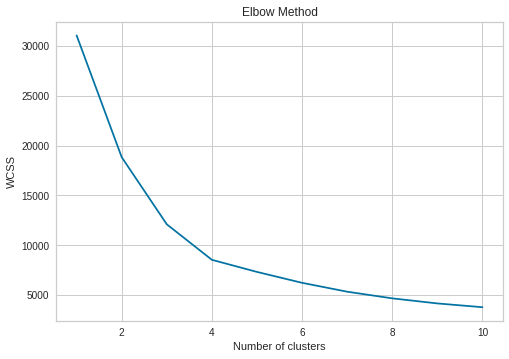

array([[ 0.33989018,  3.6688302 ],
       [ 3.0736988 ,  5.1767054 ],
       [ 4.9607196 , -0.13669515],
       ...,
       [-5.554351  ,  1.365526  ],
       [-5.4969068 ,  4.0655546 ],
       [-5.3321877 ,  1.7291437 ]], dtype=float32)

In [ ]:

doc_tags = list(model.docvecs.doctags.keys())
X = model[doc_tags]
elbow_pca(X)



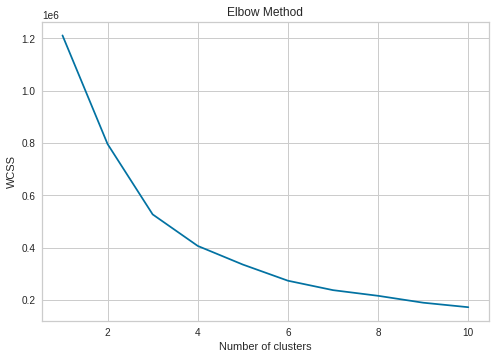

array([[-10.148244 ,  43.927975 ],
       [-14.262778 ,  52.553894 ],
       [-11.06847  ,  -7.7708664],
       ...,
       [ 12.052135 ,  37.015976 ],
       [-47.011307 , -24.833628 ],
       [ -1.1272444,  28.505623 ]], dtype=float32)

In [ ]:

elbow_tsne(X)

In [ ]:
print("k-means:\n")
model,newlables= kmean(3,X)

k-means:



In [ ]:
kappa(newlables)

0.67623701893708


Silhouetter Score: 0.021


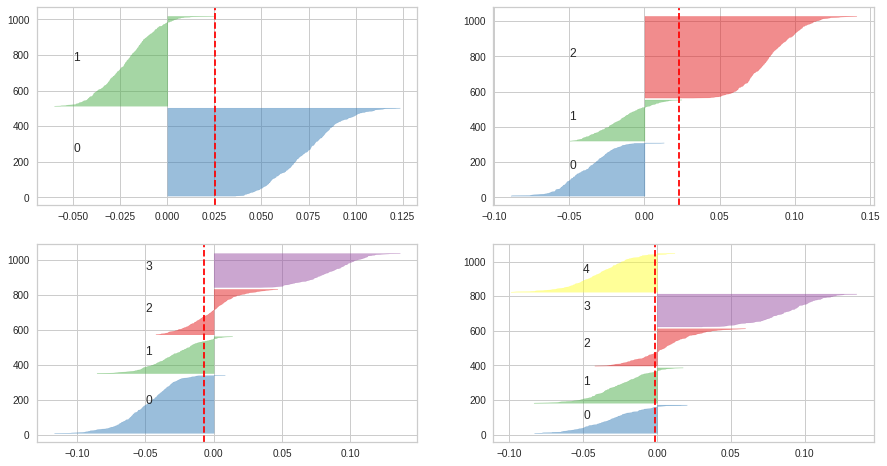

In [ ]:
silhouette(X,newlables)

In [ ]:
#Hierarchical Agglomerative Clustering 
print("Hierarchical Agglomerative Clustering:\n")
print("Euclidean distance:\n")
model,newlables= agg(3,X,'manhattan','average')

Hierarchical Agglomerative Clustering:

Euclidean distance:



In [ ]:
kappa(newlables)


0.631911532385466


Silhouetter Score: 0.030


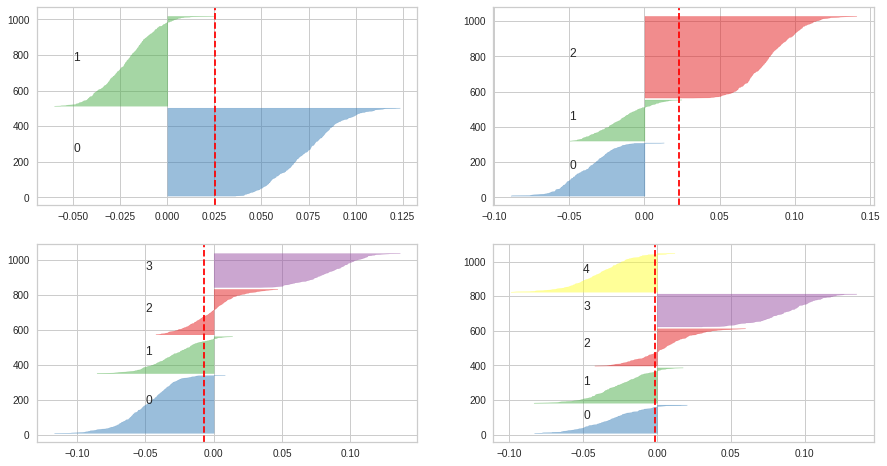

In [ ]:
silhouette(X,newlables)

In [ ]:
print("Manhattan distance:\n")
model,newlables= agg(3,X,'manhattan','complete')

Manhattan distance:



In [ ]:
kappa(newlables)

0.9544597989949749


Silhouetter Score: 0.042


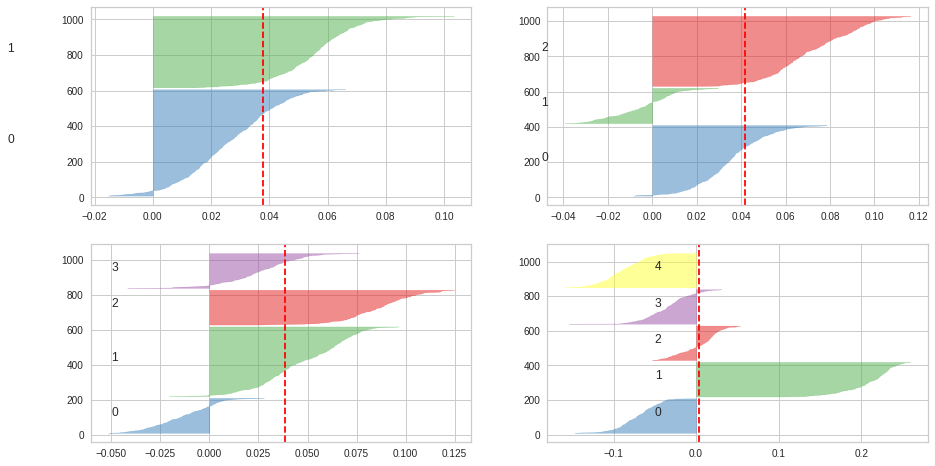

In [ ]:
silhouette(X,newlables)

In [ ]:
#EM
print("EM:\n")
model,newlables= em(3,X)

EM:



In [ ]:
kappa(newlables)


0.0


Silhouetter Score: 0.012


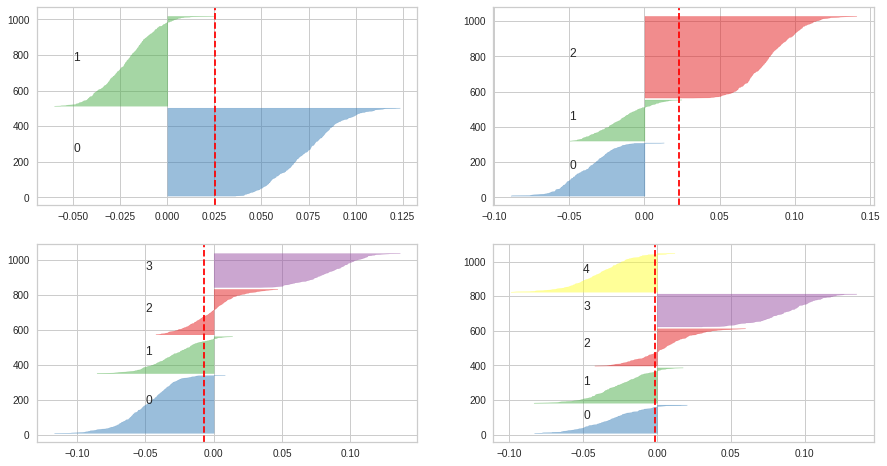

In [ ]:
silhouette(X,newlables)

In [ ]:
# from sklearn.datasets import make_blobs
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_samples, silhouette_score

# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# import numpy as nptrue_labels

# range_n_clusters = [2, 3, 4, 5, 6]
# X=text_counts.toarray()
# for n_clusters in range_n_clusters:
#     # Create a subplot with 1 row and 2 columns
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     fig.set_size_inches(18, 7)

#     # The 1st subplot is the silhouette plot
#     # The silhouette coefficient can range from -1, 1 but in this example all
#     # lie within [-0.1, 1]
#     ax1.set_xlim([-0.1, 1])
#     # The (n_clusters+1)*10 is for inserting blank space between silhouette
#     # plots of individual clusters, to demarcate them clearly.
#     ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

#     # Initialize the clusterer with n_clusters value and a random generator
#     # seed of 10 for reproducibility.
#     clusterer = KMeans(n_clusters=n_clusters, random_state=10)
#     cluster_labels = clusterer.fit_predict(X)

#     # The silhouette_score gives the average value for all the samples.
#     # This gives a perspective into the density and separation of the formed
#     # clusters
#     silhouette_avg = silhouette_score(X, cluster_labels)
#     print("For n_clusters =", n_clusters,
#           "The average silhouette_score is :", silhouette_avg)

#     # Compute the silhouette scores for each sample
#     sample_silhouette_values = silhouette_samples(X, cluster_labels)

#     y_lower = 10
#     for i in range(n_clusters):
#         # Aggregate the silhouette scores for samples belonging to
#         # cluster i, and sort them
#         ith_cluster_silhouette_values = \
#             sample_silhouette_values[cluster_labels == i]

#         ith_cluster_silhouette_values.sort()

#         size_cluster_i = ith_cluster_silhouette_values.shape[0]
#         y_upper = y_lower + size_cluster_i

#         color = cm.nipy_spectral(float(i) / n_clusters)
#         ax1.fill_betweenx(np.arange(y_lower, y_upper),
#                           0, ith_cluster_silhouette_values,
#                           facecolor=color, edgecolor=color, alpha=0.7)

#         # Label the silhouette plots with their cluster numbers at the middle
#         ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

#         # Compute the new y_lower for next plot
#         y_lower = y_upper + 10  # 10 for the 0 samples

#     ax1.set_title("The silhouette plot for the various clusters.")
#     ax1.set_xlabel("The silhouette coefficient values")
#     ax1.set_ylabel("Cluster label")

#     # The vertical line for average silhouette score of all the values
#     ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

#     ax1.set_yticks([])  # Clear the yaxis labels / ticks
#     ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

#     # 2nd Plot showing the actual clusters formed
#     colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
#     ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
#                 c=colors, edgecolor='k')

#     # Labeling the clusters
#     centers = clusterer.cluster_centers_
#     # Draw white circles at cluster centers
#     ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
#                 c="white", alpha=1, s=200, edgecolor='k')

#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
#                     s=50, edgecolor='k')

#     ax2.set_title("The visualization of the clustered data.")
#     ax2.set_xlabel("Feature space for the 1st feature")
#     ax2.set_ylabel("Feature space for the 2nd feature")

#     plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
#                   "with n_clusters = %d" % n_clusters),
#                  fontsize=14, fontweight='bold')

# plt.show()

#LDA

In [ ]:

from nltk.tokenize import word_tokenize
newsequence=[]
for s in sequence:
  newsequence.append(word_tokenize(s))

  # https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0


In [ ]:
!pip install pyLDAvis==2.1.2

     |████████████████████████████████| 1.6MB 12.7MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97738 sha256=f9ab909cb58aaedc70e26b3aa000ed2bd8b5fc61f92ed5c6ced60b7e67b66df0
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [ ]:
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
docs= newsequence
id2word = corpora.Dictionary(docs)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in docs]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [ ]:
coherence(lda_model)

-4.1605266195149575
-8.330102097649203


In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

In [ ]:
import matplotlib.colors as mcolors
mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()] 
topics = lda_model.show_topics(num_words=500,formatted=False)



l1=df.sequence[40].split()
l1=l1[0:30]

word_pos=0.06
w=[]
w.append(list(dict(list(topics[0][1])).keys()))
w.append(list(dict(list(topics[1][1])).keys()))
w.append(list(dict(list(topics[2][1])).keys()))
w.append(list(dict(list(topics[3][1])).keys()))
w.append(list(dict(list(topics[4][1])).keys()))
print(len(w))
flag=0

for word in l1:
  i=0
  for s in w:
    if word in s:
      flag=1
      break
    else:
      flag=0
    i=i+1
  if flag==1:
     
      plt.text(word_pos, 0.5,word,fontsize=32,color=mycolors[i])  
      plt.axis('off')
      word_pos += 0.3
  else:
      plt.text(word_pos,0.5,word,fontsize=16)  
      plt.axis('off')
      word_pos += 0.3 



In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=docs)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.5949,"one, men, old, day, like, would, could, good, ...","[laili, laili, saw, blind, pray, khuda, restor..."
1,1,3.0,0.5195,"one, men, old, day, like, would, could, good, ...","[thing, stick, rope, agre, princ, shot, first,..."
2,2,4.0,0.7480,"child, yet, water, cloth, hand, head, boar, ir...","[heart, raja, rasalu, go, potter, ask, sell, k..."
3,3,3.0,0.5188,"one, men, old, day, like, would, could, good, ...","[judgment, bustl, ceas, hall, justic, close, m..."
4,4,3.0,0.7576,"one, men, old, day, like, would, could, good, ...","[never, draw, bridl, find, narrow, ravin, outl..."
5,5,1.0,0.4485,"among, river, teacher, god, mani, peopl, new, ...","[day, last, exhaust, chombu, carri, alway, ful..."
6,6,3.0,0.5864,"one, men, old, day, like, would, could, good, ...","[phalana, countri, call, munsuk, raja, daughte..."
7,7,4.0,0.8291,"child, yet, water, cloth, hand, head, boar, ir...","[began, weep, water, began, slowli, rise, reac..."
8,8,0.0,0.8846,"lion, stori, templ, mr, artist, common, part, ...","[tale, translat, mr, rhi, david, _buddhist, bi..."
9,9,4.0,0.5724,"child, yet, water, cloth, hand, head, boar, ir...","[love, shawl, gave, splendid, shawl, spread, p..."


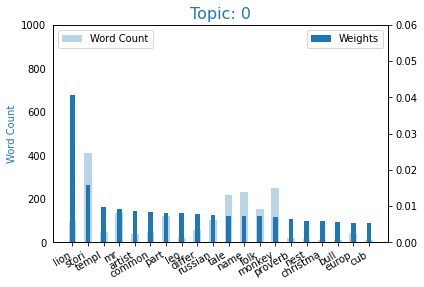

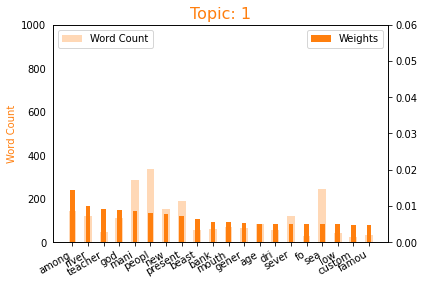

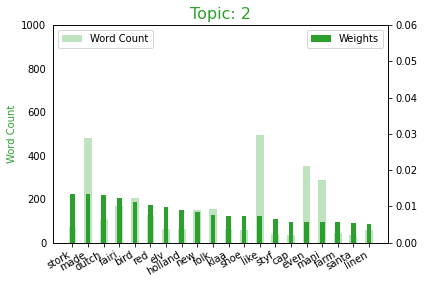

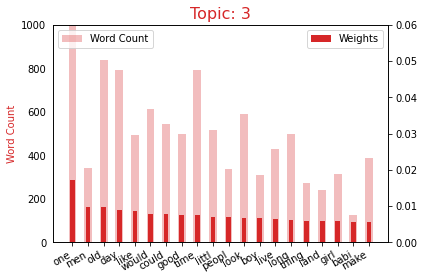

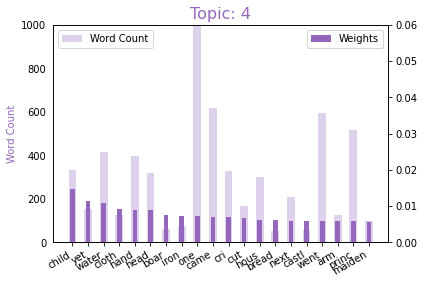

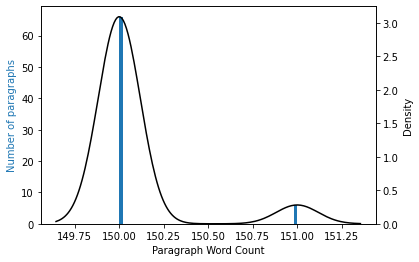

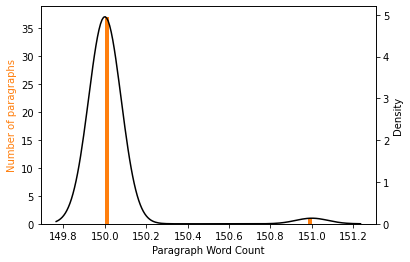

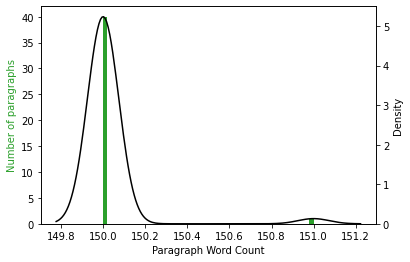

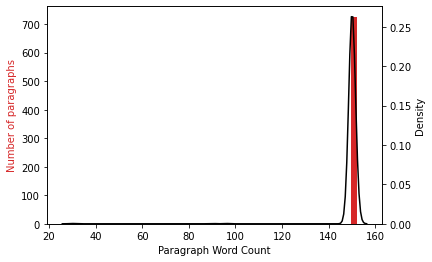

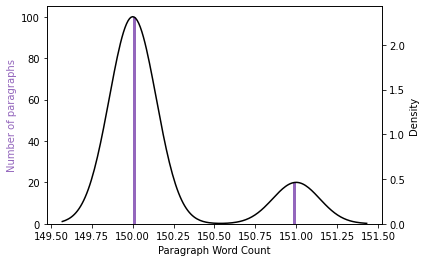

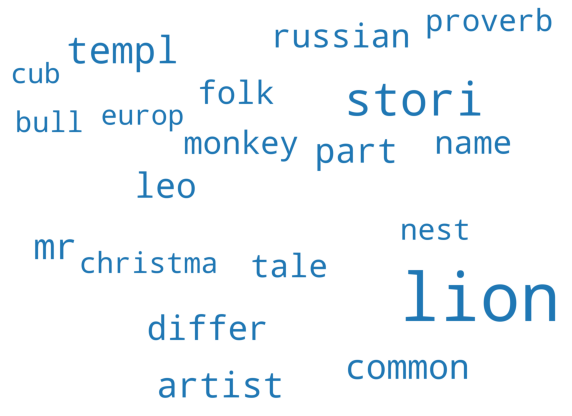

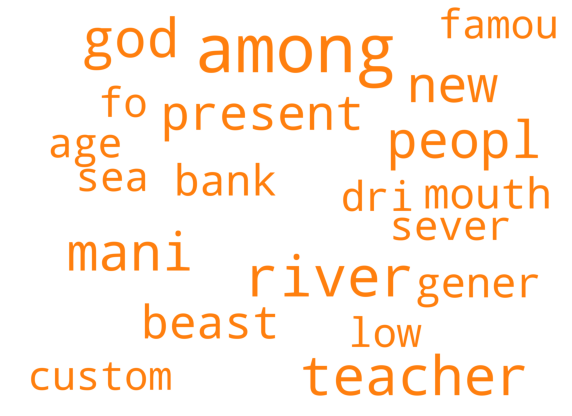

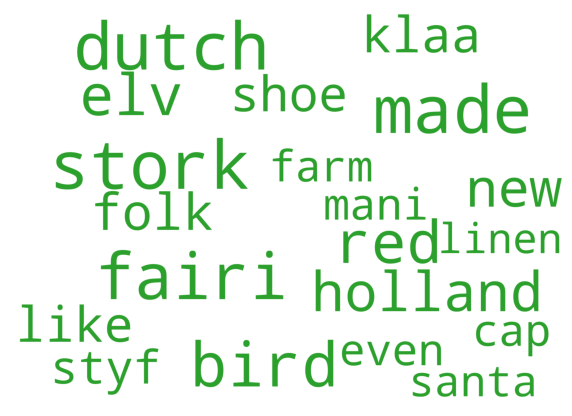

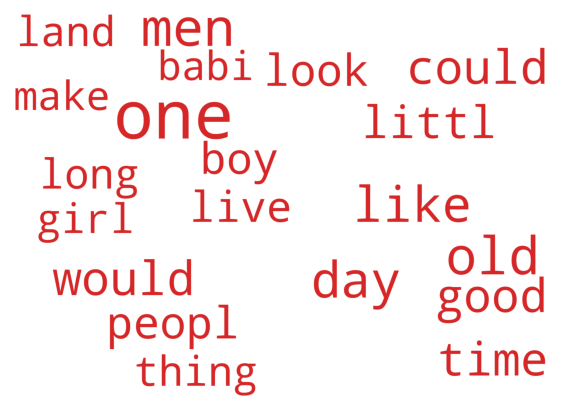

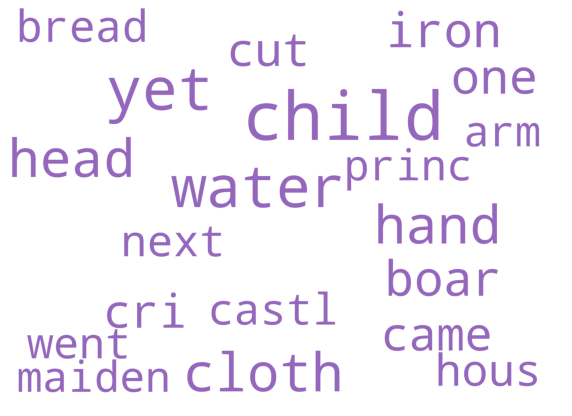

In [ ]:
#first plot
from collections import Counter
import matplotlib.colors as mcolors
from matplotlib.figure import Figure
import sys
from pylab import *
topics = lda_model.show_topics(num_words=20,formatted=False)
data_flat = [w for w_list in docs for w in w_list]
counter = Counter(data_flat)

out = []

for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count']) 
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i in range(len(topics)):
   fig, ax = plt.subplots()
   ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
   ax_twin = ax.twinx()
   ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.3, label='Weights')
   ax.set_ylabel('Word Count', color=cols[i])
   ax_twin.set_ylim(0, 0.060); ax.set_ylim(0, 1000)
   ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
   ax.tick_params(axis='y', left=False)
   ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
   ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
#####################
#second plot

for i in range(len(df_dominant_topic.Dominant_Topic.unique())):
  df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
  doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
  fig, ax = plt.subplots()
  ax.hist(doc_lens, bins = 50, color=cols[i])
  sns.kdeplot(doc_lens, color="black", shade=False,ax=ax.twinx())
  ax.set_xlabel('Paragraph Word Count')
  ax.set_ylabel('Number of paragraphs', color=cols[i])
  plt.gca() 
###################
#third plot
stop_words=set(stopwords.words("english"))
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False,num_words=20)
for i in range(len(topics)):
    text=dict(topics[i][1])
    cloud.generate_from_frequencies(text, max_font_size=300)
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.gca().imshow(cloud)

In [ ]:
doctowordmodel.labels_

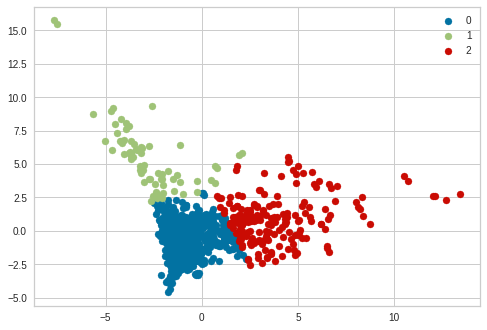

In [ ]:
#pca
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(text_counts.toarray())
doctowordmodel,label=kmean(3,X_pca)
#Getting unique labels
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(X_pca[label == i , 0] , X_pca[label == i , 1] , label = i)
plt.legend()
plt.show()